In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import torch

data = torch.load("gdrive/MyDrive/preprocessed_images_with_metadata_and_target.pt.nosync")

In [3]:
def flip_image(image):
  left_side_count = np.count_nonzero(image[:, :image.shape[1] // 2])
  right_side_count = np.count_nonzero(image[:, image.shape[1] // 2:])

  if left_side_count < right_side_count:
      flipped_image = np.fliplr(image)
  else:
      flipped_image = image
  return flipped_image

In [4]:
features = []
metadata = []
y = []

perm = torch.randperm(len(data))
idx = perm[:700]

for id in idx:
    [target, age, implant], image = data[id]
    features.append(flip_image(image.numpy()))
    metadata.append((age, implant))
    y.append(target)
del data, idx, perm

In [5]:
f_np = np.array(features).reshape((-1, 1, 512, 512))
features = torch.tensor(f_np).float()
del f_np
m_np = np.asarray(metadata).reshape((-1, 2))
metadata = torch.tensor(m_np).float()
del m_np
y = torch.tensor(y).view(-1, 1).float()

import gc
gc.collect()

9

In [6]:
features.shape

torch.Size([700, 1, 512, 512])

In [7]:
metadata.shape

torch.Size([700, 2])

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(features, metadata, y, test_size=0.15,
                                                                      random_state=3451)

train_dataset = TensorDataset(X1_train, X2_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16)

val_dataset = TensorDataset(X1_val, X2_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [9]:
def probabilistic_f1(labels, predictions, beta=1):
    pTP = np.sum(labels * predictions)
    pFP = np.sum((1 - labels) * predictions)
    num_positives = np.sum(labels)  #  = pTP+pFN

    pPrecision = pTP / (pTP + pFP)
    pRecall = pTP / num_positives

    beta_squared = beta ** 2

    if pPrecision > 0 and pRecall > 0:
        pF1 = (1 + beta_squared) * pPrecision * pRecall / (beta_squared * pPrecision + pRecall)
        return pF1
    else:
        return 0

In [10]:
results = {}

In [11]:
from torchvision.models import EfficientNet_B6_Weights
from torchvision import models
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torchvision.models._api import WeightsEnum

# Weights checksum patching: https://github.com/pytorch/vision/issues/7744
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)


WeightsEnum.get_state_dict = get_state_dict



class EfficientNetGrayWithoutClassifier(nn.Module):
    def __init__(self):
        super(EfficientNetGrayWithoutClassifier, self).__init__()
        self.base_model = models.efficientnet_b6(weights=EfficientNet_B6_Weights.DEFAULT)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(2304, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Dropout(0.7),
            nn.Sigmoid()
        )
        # self.seq_2 = nn.Sequential(
        #     nn.Linear(2, 2),
        #     nn.ReLU(),
        #     nn.Linear(2, 1),
        #     nn.Sigmoid()
        # )
        # self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        self.base_model.eval()

    def forward(self, single_channel_input, metadata):
        rgb_input = torch.cat([single_channel_input] * 3, dim=1)
        out_1 = self.base_model(rgb_input)
        # out_2 = self.seq_2(metadata)

        # out = torch.cat([out_1, out_2], dim=1)
        # out = self.linear(out)
        out = self.sigmoid(out_1)

        return out

In [12]:
model = EfficientNetGrayWithoutClassifier()
print(model)

EfficientNetGrayWithoutClassifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
              (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace

In [13]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_auc_score
from matplotlib import pyplot as plt
from torch import optim

model = EfficientNetGrayWithoutClassifier().to('cuda')

for param in model.parameters():
    param.requires_grad_(True)

for i in range(5):
  for param in model.base_model.features[i].parameters():
      param.requires_grad_(False)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 200

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    plt.clf()
    running_loss = 0.0
    model.train()
    train_predictions = []
    train_labels = []

    for i, data in enumerate(train_dataloader, 0):
        inputs1, inputs2, labels = data
        inputs1, inputs2, labels = inputs1.to('cuda'), inputs2.to('cuda'), labels.to('cuda')


        optimizer.zero_grad()

        outputs = model(inputs1*255, inputs2)
        loss = criterion(outputs, labels)

        train_predictions.extend(outputs.detach().cpu().numpy().flatten())
        train_labels.extend(labels.detach().cpu().numpy().flatten())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / (i + 1)
    train_losses.append(train_loss)
    train_f1 = probabilistic_f1(np.asarray(train_labels), np.round(train_predictions, decimals=2))
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs1, inputs2, labels = data
            inputs1, inputs2, labels = inputs1.to('cuda'), inputs2.to('cuda'), labels.to('cuda')

            outputs = model(inputs1*255, inputs2)
            loss = criterion(outputs, labels)

            val_predictions.extend(outputs.detach().cpu().numpy().flatten())
            val_labels.extend(labels.detach().cpu().numpy().flatten())

            val_loss += loss.item()

    val_loss = val_loss / (i + 1)
    val_losses.append(val_loss)
    val_f1 = probabilistic_f1(np.asarray(val_labels), np.asarray(val_predictions))
    val_f1_scores.append(val_f1)

    print(
        f'Epoch {epoch + 1}, Validation Loss: {round(val_loss, 3)}, F1 Score: {round(val_f1, 3)} Training Loss: {round(train_loss, 3)}, F1 Score: {round(train_f1, 3)}')




Epoch 1, Validation Loss: 0.696, F1 Score: 0.57 Training Loss: 0.713, F1 Score: 0.555
Epoch 2, Validation Loss: 0.697, F1 Score: 0.57 Training Loss: 0.706, F1 Score: 0.559
Epoch 3, Validation Loss: 0.695, F1 Score: 0.566 Training Loss: 0.698, F1 Score: 0.562
Epoch 4, Validation Loss: 0.682, F1 Score: 0.559 Training Loss: 0.687, F1 Score: 0.567
Epoch 5, Validation Loss: 0.664, F1 Score: 0.587 Training Loss: 0.683, F1 Score: 0.572
Epoch 6, Validation Loss: 0.696, F1 Score: 0.573 Training Loss: 0.678, F1 Score: 0.578
Epoch 7, Validation Loss: 0.663, F1 Score: 0.578 Training Loss: 0.678, F1 Score: 0.575
Epoch 8, Validation Loss: 0.648, F1 Score: 0.586 Training Loss: 0.677, F1 Score: 0.577
Epoch 9, Validation Loss: 0.685, F1 Score: 0.594 Training Loss: 0.676, F1 Score: 0.58
Epoch 10, Validation Loss: 0.685, F1 Score: 0.612 Training Loss: 0.673, F1 Score: 0.579
Epoch 11, Validation Loss: 0.65, F1 Score: 0.593 Training Loss: 0.676, F1 Score: 0.575
Epoch 12, Validation Loss: 0.658, F1 Score: 0

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

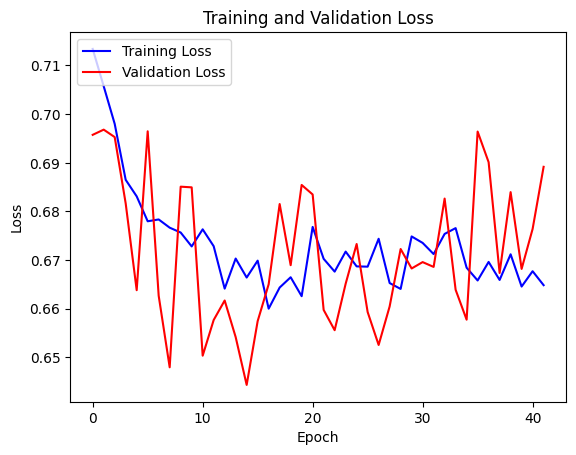

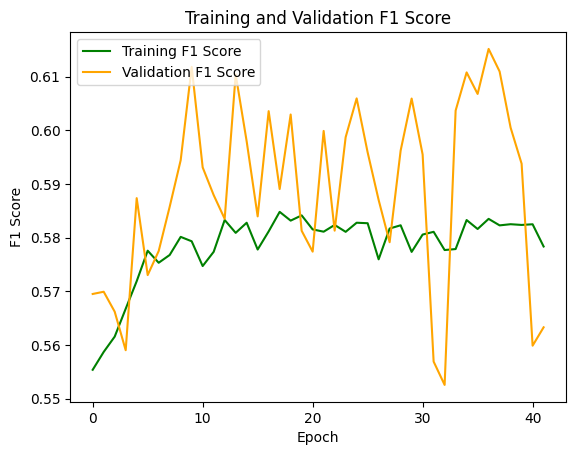

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Real-time visualization
plt.figure(1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.figure(2)
plt.plot(train_f1_scores, label='Training F1 Score', color='green')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')
plt.title('Training and Validation F1 Score')

plt.show(block=False)

y_pred = np.asarray(val_predictions) > 0.5
accuracy = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred, average='weighted')
recall = recall_score(val_labels, y_pred, average='weighted')
auroc = roc_auc_score(val_labels, val_predictions, multi_class='ovr')

clf_name = "DeepNN - val"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': val_f1,
    'AUROC': auroc,
}
y_pred = np.asarray(train_predictions) > 0.5
accuracy = accuracy_score(train_labels, y_pred)
precision = precision_score(train_labels, y_pred, average='weighted')
recall = recall_score(train_labels, y_pred, average='weighted')
auroc = roc_auc_score(train_labels, train_predictions, multi_class='ovr')

clf_name = "DeepNN - train"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': train_f1,
    'AUROC': auroc,
}

In [15]:
results

{'DeepNN - val': {'Accuracy': 0.5333333333333333,
  'Precision': 0.28444444444444444,
  'Recall': 0.5333333333333333,
  'F1 Score': 0.5633062040479045,
  'AUROC': 0.6228134110787171},
 'DeepNN - train': {'Accuracy': 0.6,
  'Precision': 0.6701095461658843,
  'Recall': 0.6,
  'F1 Score': 0.5783654186143063,
  'AUROC': 0.7064739157762414}}